#This is the notebook for the working of the Vision Transformer model on images of different sizes and that's why here the Vision
#Transformer architecture is modified in form of ViTAR - Vision Transformer with any Resolution which support input of any Resolution. 

#for ViTAR to be working there are channels in its architecture and the concept of such channles is that - low frequency channels change
#smoothly across the grid while high frequecny oscillate rapidly and formula holds the working for this is - A = p / (10000)^(d/D)

#now below is program to demonstrate how frequency varies with the channel and the Patch Indexes (core working of ViTAR model)

#For complete documentation and step by step Understanding This project is uploaded on my Github refer that

In [8]:
import matplotlib.pyplot as plt
import numpy as np

In [11]:
def plotSinusoid(d, k = 14, D = 768, n = 10000):
    #k = index
    #D = dim
    #d = channel
    K = np.arange(0, k, 1)
    denominator = np.power(n, 2*d/D)
    y = np.sin(K/denominator)
    plt.plot(K, y)
    plt.title('d = ' + str(d))
    plt.xlabel('Patch Index')
    plt.ylabel('PE')

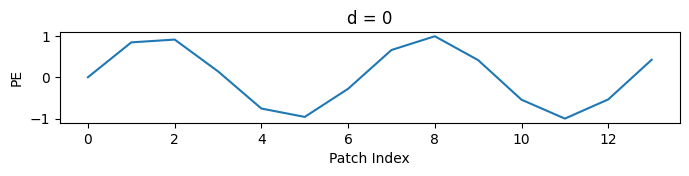

In [12]:
fig = plt.figure(figsize = (8, 4))
ax1 = plt.subplot(311)
plotSinusoid(0*100)

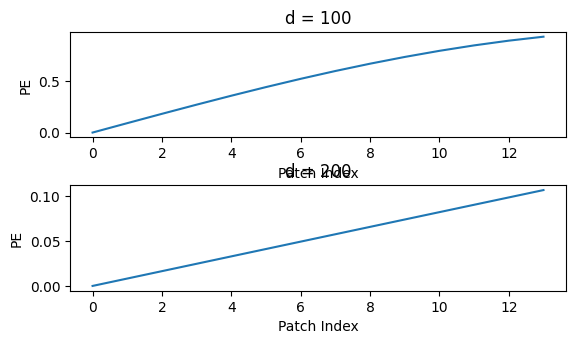

In [19]:
for i in range(1, 3):
    plt.subplot(311 + i, sharex = ax1)
    plotSinusoid(i*100)
plt.tight_layout()

#Now Visualization of the ViTAR Architecture

In [20]:
import math

In [21]:
H = W = 14 #14 X 14 = 196 patches

In [22]:
PATCHES = H * W

#Visualize Patch Indexes

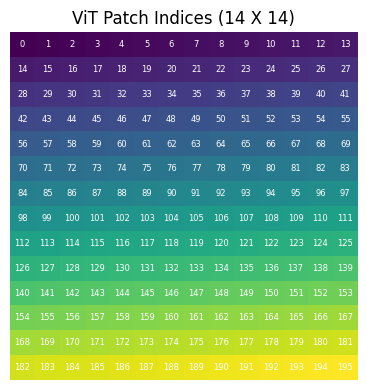

In [23]:
patch_idx = np.arange(PATCHES).reshape(H, W)

plt.figure(figsize = (4, 4))
plt.imshow(patch_idx, cmap = "viridis")
for y in range(H):
    for x in range(W):
        plt.text(x, y, patch_idx[y, x], ha = 'center', va = 'center', color = 'white', fontsize = 6)
plt.title("ViT Patch Indices (14 X 14)")
plt.axis('off'); plt.tight_layout(); plt.show()

#Config - ViT Base on 224 X 224 images (Patch16)

In [25]:
H = W = 14

#Embedding dimension in ViT Base
D = 768

#Flattened each index
p_flat = np.arange(H * W)

#Full size Sine-Cosine Table (196 X 768 )

In [26]:
pos_embed = np.zeros((H * W, D), dtype = np.float32)

#sine-cosine pair
for d in range(0, D, 2):
    div_term = 10000 ** (d / D)
    pos_embed[:, d] = np.sin(p_flat / div_term)
    pos_embed[:, d + 1] = np.cos(p_flat / div_term)

In [27]:
#reshape_tp_3D_grid
pos_grid = pos_embed.reshape(H, W, D)

#Visualize one sine channel ( d = 0)

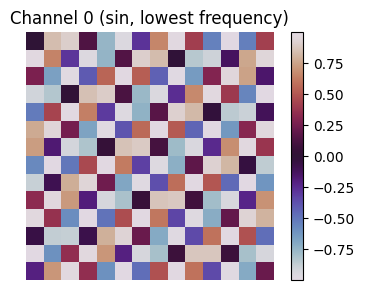

In [28]:
plt.figure(figsize = (4, 3))
plt.imshow(pos_grid[..., 0], cmap = "twilight")  # channel 0 = sin, very smooth
plt.title("Channel 0 (sin, lowest frequency)")
plt.colorbar(); plt.axis('off'); plt.tight_layout(); plt.show()

#Visualize one sine channel (d = D / 2)

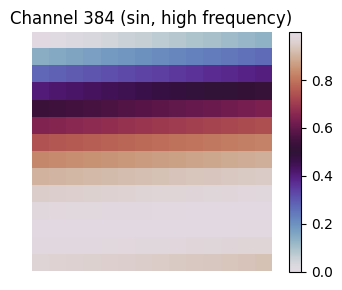

In [29]:
#midpoint -> dim -> rapid wave

hi_d = D // 2
plt.figure(figsize = (4, 3))
plt.imshow(pos_grid[..., hi_d], cmap = "twilight")
plt.title(f"Channel {hi_d} (sin, high frequency)")
plt.colorbar(); plt.axis('off'); plt.tight_layout(); plt.show()

#Plot Sine-cosine curves across **row 0, 5, 10 **

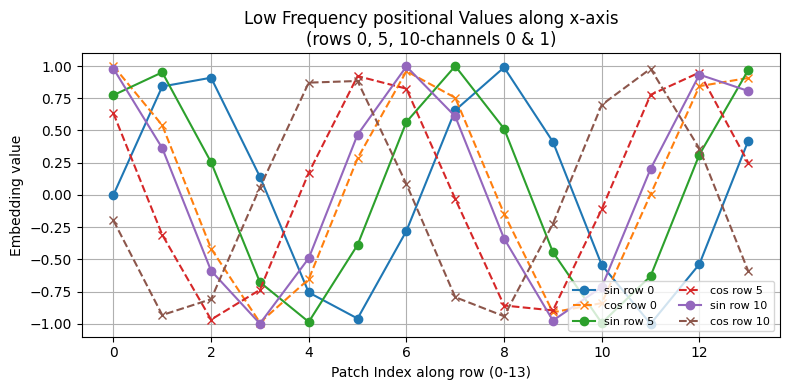

In [30]:
rows = [0, 5, 10]
plt.figure(figsize = (8, 4))

for r in rows:
    plt.plot(pos_grid[r, :, 0], marker = 'o', label = f'sin row {r}')
    plt.plot(pos_grid[r, :, 1], marker = 'x', linestyle = '--', label = f'cos row {r}')

plt.title("Low Frequency positional Values along x-axis\n(rows 0, 5, 10-channels 0 & 1)")
plt.xlabel("Patch Index along row (0-13)")
plt.ylabel("Embedding value")
plt.grid(True); plt.legend(fontsize = 8, ncol = 2); plt.tight_layout(); plt.show()

#Channels 0 and 1 are very smooth : neighbouring patches differ only a little.
#Row 0 vs Row 5 vs Row 10 curves are phase-shifted because the flat index p increases by +W(14) every time we move down one row.
#High Frequency channels(in heat map) oscillate mant times over 14 steps and gives fine spatial resolution when attends to patches.
#ViT learn "a linear projection of pixels for each patch" 
#ViT adds this 768-D positional vector to patch features.
#Self-Attention can tell where each patch is.

#Calculate Positional Embeddings in Vanilla ViT

In [33]:
!pip install torch
!pip install torchvision
import torch 
import requests
from PIL import Image
from torchvision import transforms

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 16.5 MB/s eta 0:00:00


In [34]:
#Configuration

img_size = 224
patch_size = 16
embed_dim = 768

In [35]:
#Load and Preprocess a real image
url = "https://images.unsplash.com/photo-1503023345310-bd7c1de61c7d?auto=format&fit=crop&w=224&h=224"
img = Image.open(requests.get(url, stream = True).raw).convert("RGB")
img_tensor = transforms.ToTensor()(img)

In [36]:
#Split_into Patches

patches = img_tensor.unfold(1, patch_size, patch_size).unfold(2, patch_size, patch_size)
patches = patches.permute(1, 2, 0, 3, 4).reshape(-1, 3 * patch_size * patch_size)  #(196, 768)

In [37]:
#Simple Linear projection to emulate ViT patch embedder

proj = torch.nn.Linear(patches.size(1), embed_dim, bias = False)
with torch.no_grad():
    patch_embeds = proj(patches)

#Select_few_patches_to Visualize embeddings
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)

coord_2d = pca.fit_transform(patch_embeds.numpy())

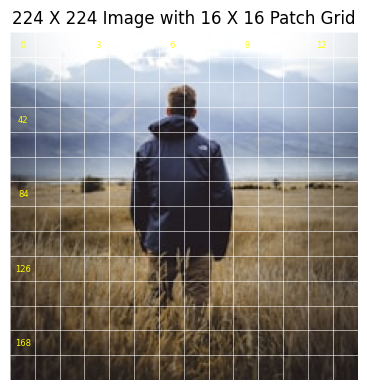

In [38]:
#Plot - 1 : Original Image with patch grid

plt.figure(figsize = (4, 4))
plt.imshow(img)
ax = plt.gca()
for i in range(0, img_size, patch_size):
    ax.axhline(i-0.5, color = 'white', linewidth = 0.4)
    ax.axvline(i-0.5, color = 'white', linewidth = 0.4)

#Annotate first row & col indices

idx = 0
for r in range(14):
    for c in range(14):
        if(r == 0 and c % 3 == 0) or (c == 0 and r % 3 == 0):
            ax.text(c * patch_size + patch_size/2, r * patch_size + patch_size/2, str(idx), color = 'yellow', fontsize = 6, ha = 'center', va = 'center')

        idx += 1

plt.title("224 X 224 Image with 16 X 16 Patch Grid")
plt.axis('off')
plt.tight_layout()
plt.show()

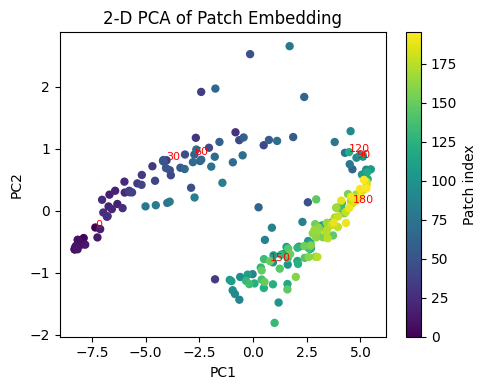

In [39]:
#Plot - 2 : 2-D PCA of 196 patch embeddings

plt.figure(figsize = (5, 4))
plt.scatter(coord_2d[:, 0], coord_2d[:, 1], c = np.arange(196), cmap = 'viridis', s = 25)
for i in range(0, 196, 30):
    plt.text(coord_2d[i, 0], coord_2d[i, 1], str(i), color = 'red', fontsize = 8)

plt.title("2-D PCA of Patch Embedding")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label = "Patch index")
plt.tight_layout()
plt.show()

#Fuzzy Positional Encoding - ViTAR (main concept)

#Config - ViT Base - patch16 - 224 X 224 -> 14 X 14 grid

In [41]:
#Original grid

H0 = W0 = 14

#Embedding dim
D = 768

#sin/cos pair using Transformer formula

def build_sincos_table(H, W, D):
    p_flat = np.arange(H * W)
    table = np.zeros((H * W, D), np.float32)
    for d in range(0, D, 2):
        angle = p_flat / 10000 ** (d/D)
        table[:, d] = np.sin(angle)
        table[:, d + 1] = np.cos(angle)
    return table.reshape(H, W, D)
pos14 = build_sincos_table(H0, W0, D) #Vanilla Table

#Visualize Patch Indices

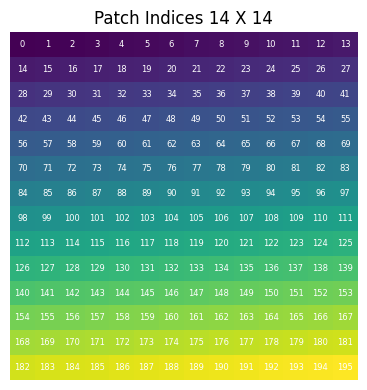

In [42]:
patch_idx = np.arange(H0 * W0).reshape(H0, W0)
plt.figure(figsize = (4, 4))
plt.imshow(patch_idx, cmap = "viridis")
for y in range(H0):
    for x in range(W0):
        plt.text(x, y, patch_idx[y, x], ha = 'center', va = 'center', color = 'white', fontsize = 6)
plt.title("Patch Indices 14 X 14"); plt.axis('off'); plt.tight_layout(); plt.show()

#Interpolate -> 24 X 24 -> ViTAR style Fuzzy Encoding -> Unsample each channel like an image (bicubic)

In [44]:
H1 = W1 = 24   #new grid for 384 X 384 grid

pos24 = np.zeros((H1, W1, D), np.float32)

for d in range(D):
    #normalize channel to 0-255
    ch = pos14[..., d]
    ch_img = Image.fromarray(((ch - ch.min()) / np.ptp(ch) * 255).astype(np.uint8))
    ch_up = ch_img.resize((W1, H1), Image.Resampling.BICUBIC)

    ch_up = np.asarray(ch_up).astype(np.float32) / 255 * np.ptp(ch) + ch.min()
    pos24[..., d] = ch_up

#Compare one (d = 0) Before vs After

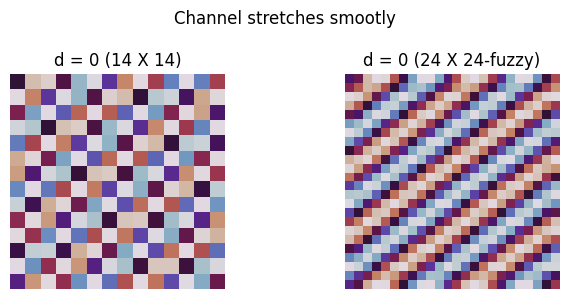

In [45]:
fig, ax = plt.subplots(1, 2, figsize = (7, 3))
ax[0].imshow(pos14[..., 0], cmap = "twilight"); ax[0].set_title("d = 0 (14 X 14)"); ax[0].axis('off')
ax[1].imshow(pos24[..., 0], cmap = "twilight"); ax[1].set_title("d = 0 (24 X 24-fuzzy)"); ax[1].axis('off')
plt.suptitle("Channel stretches smootly"); plt.tight_layout(); plt.show()

#Compare one (d = D // 2) Before vs After

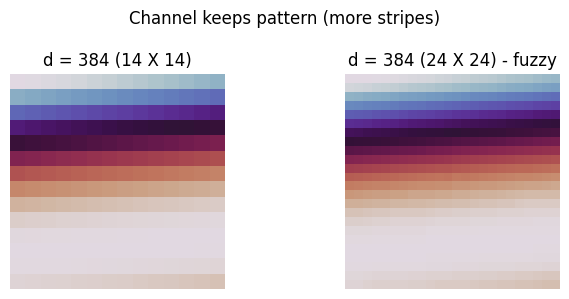

In [46]:
hi = D // 2
fig, ax = plt.subplots(1, 2, figsize = (7, 3))
ax[0].imshow(pos14[..., hi], cmap = "twilight"); ax[0].set_title(f"d = {hi} (14 X 14)")
ax[1].imshow(pos24[..., hi], cmap = "twilight"); ax[1].set_title(f"d = {hi} (24 X 24) - fuzzy")
for a in ax: a.axis('off')
plt.suptitle("Channel keeps pattern (more stripes)"); plt.tight_layout(); plt.show()

#Plot curves along row - 0 for (d, d + 1)

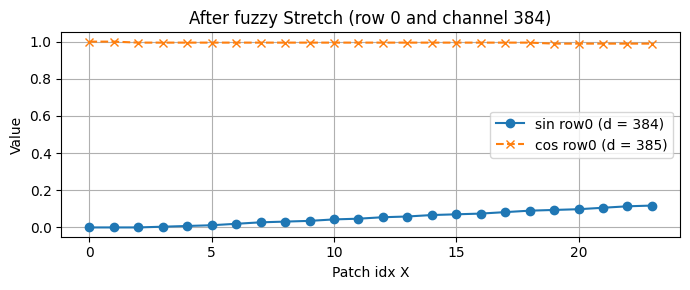

In [47]:
row = 0
plt.figure(figsize = (7, 3))
plt.plot(pos24[row, :, hi], 'o-', label = f'sin row0 (d = {hi})')
plt.plot(pos24[row, : , hi + 1], 'x--', label = f'cos row0 (d = {hi + 1})')
plt.grid(True); plt.xlabel("Patch idx X"); plt.ylabel("Value")
plt.title(f"After fuzzy Stretch (row 0 and channel {hi})")
plt.legend(); plt.tight_layout(); plt.show()

#Plot curves along row - 0 and for (d = 0, 1)

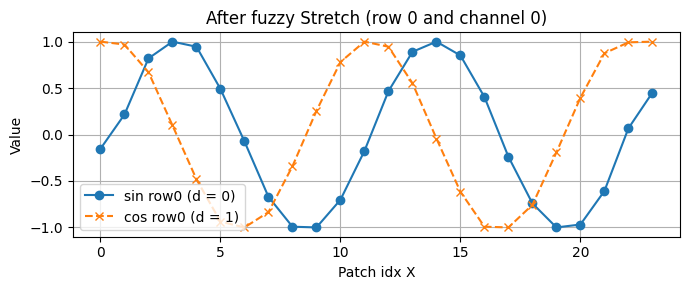

In [48]:
plt.figure(figsize = (7, 3))
plt.plot(pos24[row, :, 0], 'o-', label = 'sin row0 (d = 0)')
plt.plot(pos24[row, :, 1], 'x--', label = 'cos row0 (d = 1)')
plt.grid(True); plt.xlabel("Patch idx X"); plt.ylabel("Value")
plt.title("After fuzzy Stretch (row 0 and channel 0)")
plt.legend(); plt.tight_layout(); plt.show()

#Fuzzy Encoding = resize every channel like an image (bicubix).
#Low-freq stay smooth, high-freq channel keep stripes.
#no new information is invented - pattern just stretches.
#ViTAR preserves positional meaning at larger resolution